In [1]:
import string
from string import digits
import numpy as np
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/drive', force_remount=True)

# DOWNLOADS
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
sw = stopwords.words("english")

########## CONFIG ##########
notebook_drive_path = '/drive/MyDrive/Colab Notebooks/Hermes_reviews_experiment/'
MAX_DF = 1.0
MIN_DF = 1
EPS = 0.8
MIN_SAMPLES = 2
TARGET_TOPICS = 3
########## CONFIG ##########

Mounted at /drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


1) Loading CSV...
2) Extracting topic tokens...

Tokens vocabulary:
['air' 'famili' 'friend' 'guid' 'lawn' 'mainten' 'monument' 'natur'
 'order' 'outdoor' 'picnic' 'place' 'restaur' 'rude' 'servic' 'staff'
 'toilet' 'view' 'waiter']


3) Generating TF-IDF matrix...

Vocabulary Size :  19
Shape of Matrix :  (11, 19)

4) Clustering...

Clusterer: DBSCAN

5)Generating clusters dataframe...


0    5
1    4
2    2
Name: Cluster, dtype: int64


6) Saving clusters csv...

7) Analizing clusters for topics extraction...

Num of clusters (with possible noise cluster = -1): 3
Clusters labels:  [0 1 2]


CLUSTERS:
---------------------
Cluster 0

Tokenizing...


Original terms
['air' 'beautiful' 'bring' 'clean' 'definitely' 'eat' 'enjoy' 'family'
 'friends' 'great' 'immerse' 'lawns' 'like' 'nature' 'outdoors' 'perfect'
 'picnic' 'picnicking' 'place' 'really' 'relaxing' 'restaurant'
 'restaurants' 'return' 's' 'soon' 'stunning' 'surrounded' 'vast' 'views']

Nouns only:
['air', 'family', 'lawns', 'n

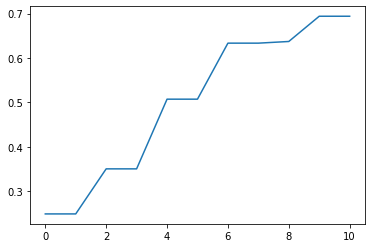

In [2]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def filter_nouns(sentence):
  tokenized = nltk.word_tokenize(sentence)
  nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')]
  return nouns

def clean(sentence):
    only_nouns = filter_nouns(sentence)
    lower_case = ' '.join(only_nouns).lower()
    no_punctuation = re.sub(r"[,.'’‘\"“”:;/*()%@#?§£Є°#\\^\+\-ç!&$]+\ *", " ", lower_case)
    no_escape = re.sub(r'(\r\n|\n|\r|\t)', ' ', no_punctuation)
    no_urls = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ', no_escape)
    no_emoji = re.sub(r"["u"\U0001F600-\U0001F64F"
                  u"\U0001F300-\U0001F5FF"  
                  u"\U0001F680-\U0001F6FF"  
                  u"\U0001F1E0-\U0001F1FF" 
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", no_urls, flags=re.UNICODE)
    only_alpha = re.sub("[^a-z]+", " ", no_emoji)
    no_digits = only_alpha.translate(str.maketrans('', '', digits))
    return no_digits


def tokenize(sentence):
    cleaned = clean(sentence)
    lemmatized = [lemmatizer.lemmatize(word) for word in str(cleaned).split() if word not in sw]
    stemmed = [stemmer.stem(word) for word in lemmatized]
    return stemmed


print('1) Loading CSV...')
df = pd.read_csv(notebook_drive_path + 'test.csv', index_col=0)
#df = pd.read_csv(notebook_drive_path + 'splitted/Greenwich.csv', index_col=0)

print('2) Extracting topic tokens...')
cv = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF, analyzer=tokenize)
x_cv = cv.fit_transform(df['Review']).toarray()

print('\nTokens vocabulary:')
print(cv.get_feature_names_out())
print('\n')

print('3) Generating TF-IDF matrix...\n')
tfidf_converter = TfidfTransformer()
x_tf_matrix = tfidf_converter.fit_transform(x_cv).toarray()

print('Vocabulary Size : ', len(cv.get_feature_names_out()))
print('Shape of Matrix : ', x_tf_matrix.shape)

print('\n4) Clustering...')

clusterer = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='cosine', n_jobs=-1)

clusterer_name = 'DBSCAN'
print('\nClusterer: ' + clusterer_name)
result = clusterer.fit_predict(x_tf_matrix)

print('\n5)Generating clusters dataframe...')
clusters_df = pd.DataFrame(columns=['Review', 'Cluster'], data=zip(df['Review'], result))
print('\n')
print(clusters_df['Cluster'].value_counts())
print('\n')
print('6) Saving clusters csv...')
clusters_df.to_csv(notebook_drive_path + clusterer_name + '_test_clusters.csv')

print('\n7) Analizing clusters for topics extraction...')

clusters = clusters_df['Cluster'].unique()
print('\nNum of clusters (with possible noise cluster = -1):', len(clusters))
print('Clusters labels: ', clusters)
print('\n')

print('CLUSTERS:')

clusters_df['Cluster_topics'] = None

clusters_topics = dict()

for cluster in clusters:
  topics = []

  print('---------------------')
  print('Cluster ' + (str(cluster) + '\n' if cluster != -1 else 'NOISY:\n'))
  cluster_reviews = clusters_df.query("Cluster == " + str(cluster))
  reviews = cluster_reviews['Review'].tolist()

  print('Tokenizing...\n')
  tokenizer = RegexpTokenizer(r'\w+')
  tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        tokenizer = tokenizer.tokenize)

  data = tfidf.fit_transform(reviews) 
  terms = tfidf.get_feature_names_out()
  print('\nOriginal terms')
  print(terms)
  print('\nNouns only:')
  nouns = filter_nouns(' '.join(terms))
  print(nouns)

  print('\nApplying LDA...\n')
  model=LatentDirichletAllocation(n_components=1)
  model.fit_transform(data)
  lda_components=model.components_

  for index, component in enumerate(lda_components):
      zipped = zip(nouns, component)
      top_nouns_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:TARGET_TOPICS]
      top_nouns_list=list(dict(top_nouns_key).keys())
      topics = topics + top_nouns_list
     
  print("\nTOPICS: ", topics)
  clusters_topics[cluster] = topics
  print('---------------------')

clusters_df['Cluster_topics'] = clusters_df.apply(lambda row: clusters_topics[row['Cluster']], axis = 1)

print('\n8) Saving labeled clusters csv...')
clusters_df.to_csv(notebook_drive_path + clusterer_name + '_test_clusters_LABELED.csv')

print('\n\nDONE:\n\n')
print(clusters_df)

print('\nε estimation\n')

#Calculate the average distance between each point in the data set and its 20 nearest neighbors (my selected MinPts value).
neighbors = NearestNeighbors(n_neighbors=MIN_SAMPLES,  metric='cosine')
neighbors_fit = neighbors.fit(x_tf_matrix)
distances, indices = neighbors_fit.kneighbors(x_tf_matrix)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [3]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
df = pd.read_csv(notebook_drive_path + 'DBSCAN_test_clusters_LABELED.csv', index_col=0)
df

,Review,Cluster,Cluster_topics
0,"The place is really beautiful, it's full of restaurants and stunning views. I will definitely be back.",0,"['restaurants', 'lawns', 'place']"
1,"A perfect place for the family, there are vast lawns for picnicking and relaxing outdoors. The perfect place to enjoy nature.",0,"['restaurants', 'lawns', 'place']"
2,"There are no toilets, the staff are rude and a waiter insulted me.",1,"['maintenance', 'toilets', 'service']"
3,"The place is great, surrounded by nature, clean air.",0,"['restaurants', 'lawns', 'place']"
4,"In the restaurant you eat very well, I will also bring my friends",0,"['restaurants', 'lawns', 'place']"
5,"Rude staff, will never go back, bad service.",1,"['maintenance', 'toilets', 'service']"
6,"Toilets out of order, no maintenance, bad.",1,"['maintenance', 'toilets', 'service']"
7,"The monument is well cared for, fantastic, the guides very well prepared.",2,"['toner', 'guides', 'monument']"
8,The guide was very knowledgeable and friendly. We will toner.,2,"['toner', 'guides', 'monument']"
9,"It's not possible that the toilets will never work, all out of order.",1,"['maintenance', 'toilets', 'service']"
